# Never gonna give you up
# Never gonna DRAG you down

Howdy folks. Today we'll be quantum mechanic.

In [1]:
# First we set up some basic dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import qiskit as qis
import qiskit.pulse as qisp
from qiskit.circuit import Parameter, QuantumCircuit, Gate
from qiskit import IBMQ, schedule
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.compiler.assembler import MeasLevel, MeasReturnType
from qiskit.tools.monitor import job_monitor

if not IBMQ.active_account():
    IBMQ.load_account()
    
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_manila')

In [33]:
qubit = 0
drive_freq = backend.configuration().hamiltonian['vars'][f'wq{qubit}']/(2*np.pi)
# drive_coupling = backend.configuration().hamiltonian['vars'][f'omegad{qubit}']

x_sigma = 80
x_duration = 320

x_amp = 0.10218341976411754
drive_betas = np.linspace(-20, 20, 33)

drive_beta = Parameter('drive_beta')
with qisp.build(backend=backend, default_alignment='sequential') as XX_sched:
        qisp.set_frequency(drive_freq, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=x_duration,
                              amp=x_amp,
                              sigma=x_sigma,
                              beta=drive_beta), qisp.drive_channel(0))
        qisp.shift_phase(-np.pi, qisp.drive_channel(0))
        qisp.play(qisp.Drag(duration=x_duration,
                              amp=x_amp,
                              sigma=x_sigma,
                              beta=drive_beta), qisp.drive_channel(0))
        qisp.shift_phase(-np.pi, qisp.drive_channel(0))

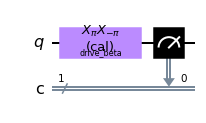

In [34]:
# n = 1

n = 1
XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
qc_DRAG = QuantumCircuit(1, 1)
n = 2*k + 1
i = 0
while i < n:
    qc_DRAG.append(XX, [0])
    i += 1
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
exp_DRAG_circuits_n1 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]
qc_DRAG.draw(output='mpl')

In [24]:
len(exp_DRAG_circuits_n1)

51

In [35]:
# n = 3

# for k in range(2):
n = 3
XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
qc_DRAG = QuantumCircuit(1, 1)
i = 0
while i < n:
    qc_DRAG.append(XX, [0])
    i += 1
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
exp_DRAG_circuits_n3 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

In [36]:
# n = 5

n = 5
XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
qc_DRAG = QuantumCircuit(1, 1)
i = 0
while i < n:
    qc_DRAG.append(XX, [0])
    i += 1
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
exp_DRAG_circuits_n5 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

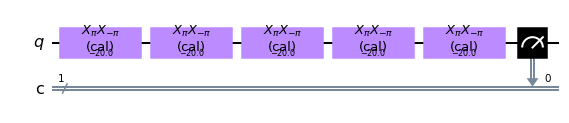

In [37]:
exp_DRAG_circuits_n5[0].draw(output='mpl')

In [38]:
# n = 7
n = 7
XX = Gate("$X_\pi X_{-\pi}$", 1, [drive_beta])
qc_DRAG = QuantumCircuit(1, 1)
i = 0
while i < n:
    qc_DRAG.append(XX, [0])
    i += 1
qc_DRAG.measure(0, 0)
qc_DRAG.add_calibration(XX, (0,), XX_sched, [drive_beta])
exp_DRAG_circuits_n7 = [qc_DRAG.assign_parameters({drive_beta: b}, inplace=False) for b in drive_betas]

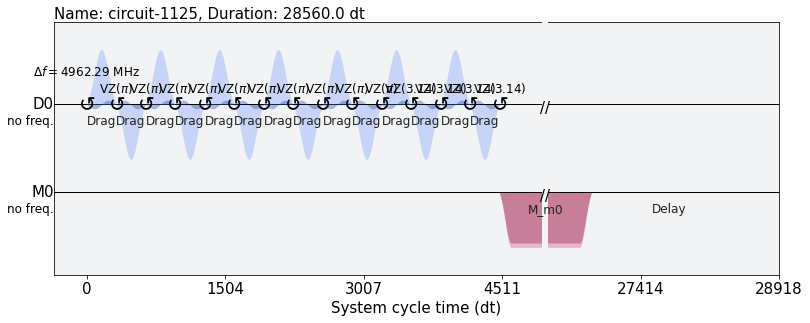

In [39]:
schedule(exp_DRAG_circuits_n7[7], backend).draw()

In [40]:
exp_DRAG_circuits = []
for i in exp_DRAG_circuits_n3:
    exp_DRAG_circuits.append(i)
for i in exp_DRAG_circuits_n5:
    exp_DRAG_circuits.append(i)
for i in exp_DRAG_circuits_n7:
    exp_DRAG_circuits.append(i)

In [41]:
drag_job = backend.run(exp_DRAG_circuits,
                       meas_level=MeasLevel.KERNELED,
                       meas_return=MeasReturnType.AVERAGE,
                       shots=2**14)

In [42]:
print(drag_job.job_id())

633d9ee5338f421278b75c38


In [43]:
job_monitor(drag_job)

Job Status: job has successfully run


In [83]:
# dragJob_n3 = backend.retrieve_job('633c44bb5765650b1c1165aa')
# dragJob_n5 = backend.retrieve_job('633c44bdbfe8f437459e2e78')
# dragJob_n7 = backend.retrieve_job('633c44bffeb64c4bf89ff98c')

In [44]:
def baselineRemover(values):
    return np.array(values) - np.mean(values)

num_beta_points = len(drive_betas)

In [65]:
drag_results = drag_job.result(timeout=120)
drag_values = []
for i in range(99):
    drag_values.append(drag_results.get_memory(i)[qubit] * 1e-7)
drag_values = np.real(baselineRemover(drag_values))

In [66]:
drag_values

array([ 1.7403545 ,  1.9046155 ,  1.9554715 ,  1.9200233 ,  1.7398355 ,
        1.4622004 ,  1.1221122 ,  0.72472785,  0.25706217, -0.19769648,
       -0.66452935, -1.0779773 , -1.4429774 , -1.7349167 , -1.9736189 ,
       -2.0645567 , -2.0717467 , -1.9667615 , -1.7826721 , -1.4532596 ,
       -1.0934027 , -0.6654104 , -0.1846203 ,  0.31042635,  0.7256965 ,
        1.0975801 ,  1.4984482 ,  1.7265929 ,  1.9024787 ,  1.9489029 ,
        1.9055737 ,  1.7506153 ,  1.4930955 , -1.9785339 , -1.6374272 ,
       -1.0587328 , -0.32192988,  0.4018418 ,  1.1140798 ,  1.6643562 ,
        1.9414309 ,  1.8876805 ,  1.5690675 ,  0.9974896 ,  0.2744593 ,
       -0.47445575, -1.2073028 , -1.7639935 , -2.0327051 , -2.0493171 ,
       -1.7506505 , -1.2573646 , -0.49484815,  0.24736805,  1.0118998 ,
        1.5842446 ,  1.8957619 ,  1.9125323 ,  1.6673558 ,  1.1406163 ,
        0.4661754 , -0.2895616 , -1.0815239 , -1.6470568 , -1.9955309 ,
       -2.0791209 ,  0.9632502 , -0.0451774 , -1.046313  , -1.83

In [67]:
drag_values_n3 = drag_values[0:33]
drag_values_n5 = drag_values[33:66]
drag_values_n7 = drag_values[66:99]

In [81]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)

    return fitparams, y_fit

In [85]:
def sinusoid(x, fit_params):
    A, B, drive_period, phi = fit_params
    return A*np.cos(2*np.pi*x/drive_period - phi) + B

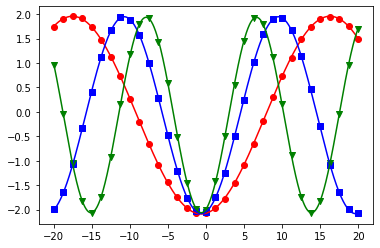

In [94]:
fit_params_n3, y_fit_n3 = fit_function(drive_betas,
                                       drag_values_n3,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [2, 0, 40, 0])
fit_params_n5, y_fit_n5 = fit_function(drive_betas,
                                       drag_values_n5,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [2, 0, 20, 0])
fit_params_n7, y_fit_n7 = fit_function(drive_betas,
                                       drag_values_n7,
                                       lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                       [2, 0, 20, 0])
x_val = np.linspace(-20, 20, 1000)
plt.scatter(drive_betas, drag_values_n3, marker='o', linestyle='-', color='red')
plt.plot(x_val, sinusoid(x_val, fit_params_n3), color = 'red')
plt.scatter(drive_betas, drag_values_n5, marker='s', linestyle='-', color='blue')
plt.plot(x_val, sinusoid(x_val, fit_params_n5), color = 'blue')
plt.scatter(drive_betas, drag_values_n7, marker='v', linestyle='-', color='green')
plt.plot(x_val, sinusoid(x_val, fit_params_n7), color = 'green')

In [95]:
min_val = 1
beta_optimum = 0
for x in x_val:
    l = (sinusoid(x, fit_params_n3) + 2)**2 + (sinusoid(x, fit_params_n5) + 2)**2 + (sinusoid(x, fit_params_n7) + 2)**2
    if l < min_val:
        min_val = l
        x_optimum = x
x_optimum

-1.3413413413413409

In [118]:
with qisp.build(backend=backend, default_alignment='sequential') as SX_sched:
    qisp.set_frequency(drive_freq, qisp.drive_channel(0))
    qisp.play(qisp.Drag(duration=x_duration,
                        amp=x_amp/2,
                        sigma=x_sigma,
                        beta=beta_optimum), qisp.drive_channel(0))


In [124]:
SX_circs = []
for i in range(100):
    qc_SX = QuantumCircuit(1, 1)
    SX = Gate("$SX$", 1, [])
    qc_SX.add_calibration(SX, (0,), SX_sched, [])
    qc_SX.append(SX, [0])
    for j in range(i):
        qc_SX.append(SX, [0])
    qc_SX.measure(qubit, 0)
    SX_circs.append(qc_SX)

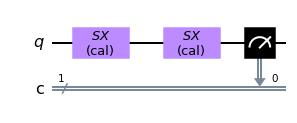

In [249]:
SX_circs[1].draw(output='mpl')

In [126]:
len(SX_circs)

100

In [130]:
SX_job = backend.run(SX_circs,
                    meas_level=2,
                    meas_return='single',
                    shots=2**14)
SX_job.job_id()

'633ea125feb64c920ea00369'

In [117]:
job_monitor(SX_job)

Job Status: job is queued (156)

KeyboardInterrupt: 

In [141]:
SX_results = SX_job.result().get_counts()

SyntaxError: invalid syntax (4191918348.py, line 1)

In [259]:
zero_population = [SX_results[i]['0']/2**14 for i in range(100)]
len(zero_population)

100

In [269]:
def SX_theory(val, epsilon):
    return [1/2 + 1/2*np.cos(np.pi/2 + n*epsilon) for n in val]

[1.55002548]


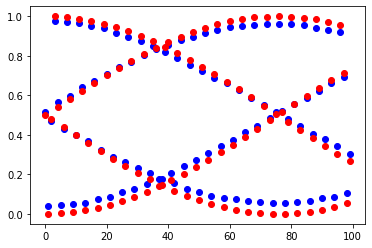

In [279]:
SX_params, SX_fit = fit_function(range(100),
                                       zero_population,
                                       SX_theory,
                                       [np.pi/2])
print(SX_params)
plt.scatter(range(100), zero_population, marker='o', linestyle='-', color='blue')
# plt.plot(range(100), SX_theory(range(100), SX_params), color='blue')
plt.scatter(range(100), SX_theory(range(100), SX_params), color='red')

In [264]:
SX_odd_circs = []
for i in range(100):
    qc_SX = QuantumCircuit(1, 1)
    SX = Gate("$SX$", 1, [])
    qc_SX.add_calibration(SX, (0,), SX_sched, [])
    qc_SX.append(SX, [0])
    for j in range(i):
        qc_SX.append(SX, [0])
        qc_SX.append(SX, [0])
    qc_SX.measure(qubit, 0)
    SX_odd_circs.append(qc_SX)


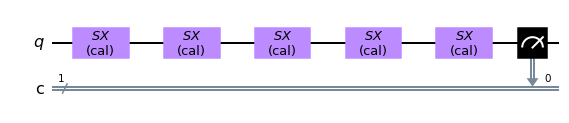

In [265]:
SX_odd_circs[2].draw(output='mpl')

In [266]:
SX_odd_job = backend.run(SX_odd_circs,
                     meas_level=2,
                     meas_return='single',
                     shots=2**14)
SX_odd_job.job_id()

'633ebe58338f42c077b76051'

In [307]:
SX_odd_results = SX_odd_job.result().get_counts()
zero_population_odd = [SX_odd_results[i]['0']/2**14 for i in range(100)]

In [308]:
def SX_odd_theory(val, epsilon):
    return [1/2 + 1/2*(-1)**n*np.cos(np.pi/2 + (2*n)*epsilon) for n in val]

[0.33291242]


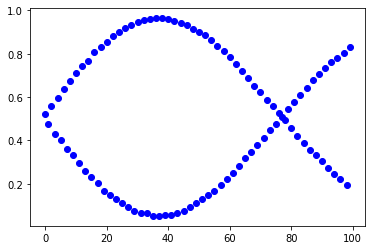

In [315]:
SX_odd_params, SX_odd_fit = fit_function(range(100),
                                 zero_population_odd,
                                 SX_odd_theory,
                                 [np.pi/10])
print(SX_odd_params)
plt.scatter(range(100), zero_population_odd, marker='o', linestyle='-', color='blue')
# plt.plot(range(100), SX_theory(range(100), SX_params), color='blue')
# plt.scatter(range(100), SX_odd_theory(range(100), SX_odd_params), color='red')